In [1]:
import numpy as np

from lmphoton import OptColumn, OptElement, OptRow, OptNetwork
from lmphoton.transforms import reflect
from lmphoton.models import Laser, Detector, BeamSplitter, DirectionalCoupler, Absorber, Waveguide, Crossing, LossElement
from lmphoton.simulation import current_simulation as sim
from lmphoton.helpers import db2mag

from functools import partial

import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

um = 1e-6

In [2]:
def directional_coupler(splitratio  = 0.5):
      a = np.sqrt(1-splitratio)
      b = 1j*np.sqrt(splitratio)

      return [[a, b,], [b, a]]

def unbalanced_arm(wavelength = 1.31e-6, length_1 = 100e-6, length_2 = 50e-6, index = 1.5, group_index=1.96):
      dn_dlambda = (group_index - index) / 1.31e-6
      index = index + (wavelength - 1.31e-6) * dn_dlambda
      wavenumber = index * 2 * np.pi / wavelength
      complex_phase_1 = wavenumber * length_1
      complex_phase_2 = wavenumber * length_2
      return [[np.exp(-1j*complex_phase_1), 0.0], [0.0, np.exp(-1j*complex_phase_2)]]

def amzi(wavelength = 1.31e-6, dc1_splitratio=0.5, dc2_splitratio=0.3, length_1=100e-6, length_2=50e-6, index=1.5, group_index=1.96):
      return np.dot(directional_coupler(dc1_splitratio), np.dot(unbalanced_arm(wavelength, length_1, length_2, index, group_index), directional_coupler(dc2_splitratio)))

In [3]:
dc1 = directional_coupler(0.5)
dc2 = directional_coupler(0.3)
unbalanced_arms = unbalanced_arm()
amzis = amzi()

print("T-matrix for dc1 =", dc1)
print("T-matrix for dc2 =",dc2)
print("T-matrix for unbalanced_arms =",unbalanced_arms)
print("T-matrix for amzi =",amzis)

T-matrix for dc1 = [[0.7071067811865476, 0.7071067811865476j], [0.7071067811865476j, 0.7071067811865476]]
T-matrix for dc2 = [[0.8366600265340756, 0.5477225575051661j], [0.5477225575051661j, 0.8366600265340756]]
T-matrix for unbalanced_arms = [[(-0.999712454653156+0.023979324664419224j), 0.0], [0.0, (-0.0119905243180617-0.9999281110792805j)]]
T-matrix for amzi = [[-0.58679395+0.40145685j  0.5822783 -0.39428066j]
 [ 0.37308413-0.59608177j  0.38009328-0.6008526j ]]


In [4]:

class unbalanced_mzi_filter(OptRow):
  def __init__(
    self,
    L_arm_1 = 150*um,
    L_arm_2 = 50*um,
    dc1 = 0.5,
    dc2 = 0.5,
    SiN_directional_coupler_loss_dB = 0.02,
    effective_index = 1.58,
    group_index = 1.94,
    XPS_loss_dB = 0.07,
    name = 'unbalanced_mzi_filter',
  ):
    
    self.Larm1 = L_arm_1
    self.Larm2 = L_arm_2

    self.dc1 = DirectionalCoupler(splitratio = dc1,loss = SiN_directional_coupler_loss_dB)
    self.dc2 = DirectionalCoupler(splitratio = dc2,loss = SiN_directional_coupler_loss_dB)

    self.wg1 = Waveguide(length = self.Larm1, index = effective_index, group_index = group_index)
    self.wg2 = Waveguide(length = self.Larm2, index = effective_index, group_index = group_index)


    optical_column_1 = OptColumn(
      [
        self.wg1,
        self.wg2
        ]
    )

    network = [
      self.dc1, 
      optical_column_1, 
      self.dc2
    ]
    
    super().__init__(
      network, 
      name = name
      )
    
  @property
  def wavelength(self):
    return sim().wavelength
  
  @wavelength.setter
  def wavelength(self, wavelength):
    sim().wavelength = wavelength

Output port 1 input top magnitude =  0.8757738188974475
Output port 2 input top magnitude =  0.11505812553674429
Output port 1 input bottom magnitude =  0.11505812553674429
Output port 2 input bottom magnitude =  0.8757738188974475
Output port 1 input top angle =  0.8753292508096691
Output port 2 input top angle =  0.8753292508078722
Output port 1 input bottom angle =  0.8753292508078722
Output port 2 input bottom angle =  -2.2662634027801243


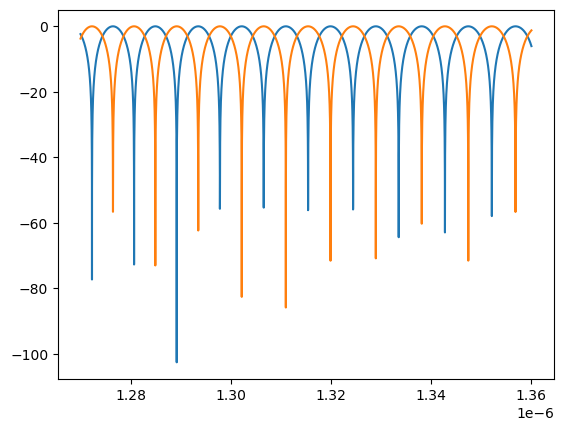

In [5]:
wavemeter = unbalanced_mzi_filter(dc1=0.5, dc2=0.5, L_arm_1=150*um, L_arm_2=50*um)
wavemeter.wavelength = 1.31e-6

input_state_top = np.array([1, 0, 0, 0])
input_state_bottom = np.array([0, 1, 0, 0])

output_state_top = wavemeter.smatrix @ input_state_top
output_state_bottom = wavemeter.smatrix @ input_state_bottom

output_port1_input_top_mag = np.abs(output_state_top[2])**2
output_port_2_input_top_mag = np.abs(output_state_top[3])**2
output_port_1_input_bottom_mag = np.abs(output_state_bottom[2])**2
output_port_2_input_bottom_mag = np.abs(output_state_bottom[3])**2

output_port1_input_top_angle = np.angle(output_state_top[2])
output_port_2_input_top_angle = np.angle(output_state_top[3])
output_port_1_input_bottom_angle = np.angle(output_state_bottom[2])
output_port_2_input_bottom_angle = np.angle(output_state_bottom[3])

print("Output port 1 input top magnitude = ", output_port1_input_top_mag)
print("Output port 2 input top magnitude = ", output_port_2_input_top_mag)
print("Output port 1 input bottom magnitude = ", output_port_1_input_bottom_mag)
print("Output port 2 input bottom magnitude = ", output_port_2_input_bottom_mag)

print("Output port 1 input top angle = ", output_port1_input_top_angle)
print("Output port 2 input top angle = ", output_port_2_input_top_angle)
print("Output port 1 input bottom angle = ", output_port_1_input_bottom_angle)
print("Output port 2 input bottom angle = ", output_port_2_input_bottom_angle)

wavelength_sweep = np.linspace(1.27e-6, 1.36e-6, 9001)

output_port_1_input_top_mag_list = []
output_port_2_input_top_mag_list = []
output_port_1_input_bottom_mag_list = []
output_port_2_input_bottom_mag_list = []

for wav in wavelength_sweep:
      wavemeter.wavelength = wav

      output_state_top = wavemeter.smatrix @ input_state_top
      output_state_bottom = wavemeter.smatrix @ input_state_bottom

      output_port_1_input_top_mag_list.append(np.abs(output_state_top[2])**2)
      output_port_2_input_top_mag_list.append(np.abs(output_state_top[3])**2)
      output_port_1_input_bottom_mag_list.append(np.abs(output_state_bottom[2])**2)
      output_port_2_input_bottom_mag_list.append(np.abs(output_state_bottom[3])**2)

plt.plot(wavelength_sweep, 10*np.log10(output_port_1_input_top_mag_list), label = 'Output port 1 input top magnitude')
plt.plot(wavelength_sweep, 10*np.log10(output_port_2_input_top_mag_list), label = 'Output port 2 input top magnitude')
plt.show()

Output port 1 input top magnitude =  0.46191804216352067
Output port 2 input top magnitude =  0.5289139022717002
Output port 1 input bottom magnitude =  0.5289139022716223
Output port 2 input bottom magnitude =  0.46191804216359855
Output port 1 input top angle =  -0.031809924399992875
Output port 2 input top angle =  0.034667761741907055
Output port 1 input bottom angle =  0.7458384447533505
Output port 2 input bottom angle =  -2.329276522694382


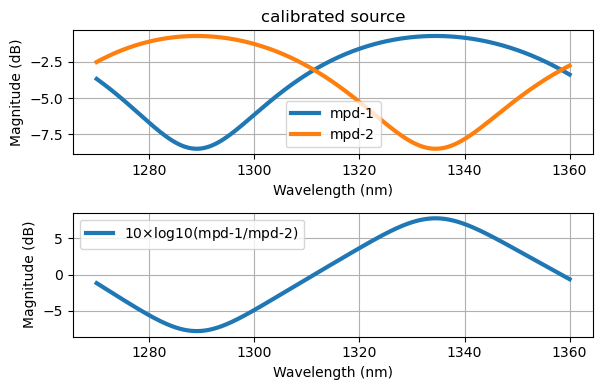

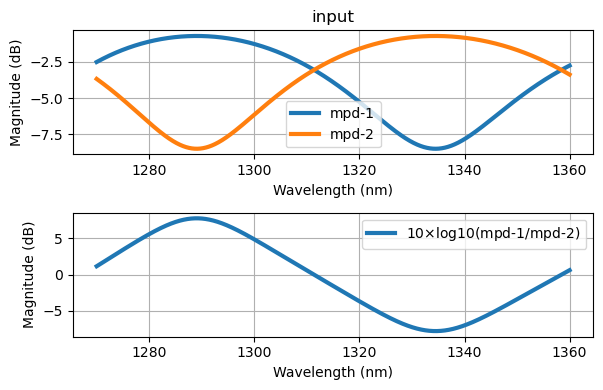

In [6]:
target_wavelength = 1.325e-6
delta_L = 10*um
neff = 1.63

filter_order = delta_L * neff / target_wavelength

filter_order_int = int(filter_order)
delta_L = filter_order_int * target_wavelength / neff

wavemeter = unbalanced_mzi_filter(dc1=0.5, dc2=0.15, L_arm_1=50*um + delta_L, L_arm_2=50*um)
wavemeter.wavelength = 1.31e-6

input_state_top = np.array([1, 0, 0, 0])
input_state_bottom = np.array([0, 1, 0, 0])

output_state_top = wavemeter.smatrix @ input_state_top
output_state_bottom = wavemeter.smatrix @ input_state_bottom

output_port1_input_top_mag = np.abs(output_state_top[2])**2
output_port_2_input_top_mag = np.abs(output_state_top[3])**2
output_port_1_input_bottom_mag = np.abs(output_state_bottom[2])**2
output_port_2_input_bottom_mag = np.abs(output_state_bottom[3])**2

output_port1_input_top_angle = np.angle(output_state_top[2])
output_port_2_input_top_angle = np.angle(output_state_top[3])
output_port_1_input_bottom_angle = np.angle(output_state_bottom[2])
output_port_2_input_bottom_angle = np.angle(output_state_bottom[3])

print("Output port 1 input top magnitude = ", output_port1_input_top_mag)
print("Output port 2 input top magnitude = ", output_port_2_input_top_mag)
print("Output port 1 input bottom magnitude = ", output_port_1_input_bottom_mag)
print("Output port 2 input bottom magnitude = ", output_port_2_input_bottom_mag)

print("Output port 1 input top angle = ", output_port1_input_top_angle)
print("Output port 2 input top angle = ", output_port_2_input_top_angle)
print("Output port 1 input bottom angle = ", output_port_1_input_bottom_angle)
print("Output port 2 input bottom angle = ", output_port_2_input_bottom_angle)

output_port_1_input_top_mag_list = []
output_port_2_input_top_mag_list = []
output_port_1_input_bottom_mag_list = []
output_port_2_input_bottom_mag_list = []

for wav in wavelength_sweep:
      wavemeter.wavelength = wav

      output_state_top = wavemeter.smatrix @ input_state_top
      output_state_bottom = wavemeter.smatrix @ input_state_bottom

      output_port_1_input_top_mag_list.append(np.abs(output_state_top[2])**2)
      output_port_2_input_top_mag_list.append(np.abs(output_state_top[3])**2)
      output_port_1_input_bottom_mag_list.append(np.abs(output_state_bottom[2])**2)
      output_port_2_input_bottom_mag_list.append(np.abs(output_state_bottom[3])**2)

output_port_1_input_top_mag = np.array(output_port_1_input_top_mag_list)
output_port_2_input_top_mag = np.array(output_port_2_input_top_mag_list)
output_port_1_input_bottom_mag = np.array(output_port_1_input_bottom_mag_list)
output_port_2_input_bottom_mag = np.array(output_port_2_input_bottom_mag_list)

plt.figure(figsize=(6,4))
plt.subplot(211)
plt.plot(wavelength_sweep*1e9, 10*np.log10(output_port_1_input_top_mag), linewidth=3.0, label = 'mpd-1')
plt.plot(wavelength_sweep*1e9, 10*np.log10(output_port_2_input_top_mag), linewidth=3.0, label = 'mpd-2')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude (dB)')
plt.title('calibrated source')
plt.grid()
plt.legend()
plt.subplot(212)
plt.plot(wavelength_sweep*1e9, 10*np.log10(output_port_1_input_top_mag/output_port_2_input_top_mag), linewidth=3.0, label = r'10$\times$log10(mpd-1/mpd-2)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.subplot(211)
plt.plot(wavelength_sweep*1e9, 10*np.log10(output_port_1_input_bottom_mag), linewidth=3.0, label = 'mpd-1')
plt.plot(wavelength_sweep*1e9, 10*np.log10(output_port_2_input_bottom_mag), linewidth=3.0, label = 'mpd-2')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude (dB)')
plt.title('input')
plt.grid()
plt.legend()
plt.subplot(212)
plt.plot(wavelength_sweep*1e9, 10*np.log10(output_port_1_input_bottom_mag/output_port_2_input_bottom_mag), linewidth=3.0, label = r'10$\times$log10(mpd-1/mpd-2)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Output port 1 input top magnitude =  0.3356634193243082
Output port 2 input top magnitude =  0.6551685251005269
Output port 1 input bottom magnitude =  0.6551685250921292
Output port 2 input bottom magnitude =  0.3356634193327059
Output port 1 input top angle =  -0.5851941389801919
Output port 2 input top angle =  -0.11370731057520948
Output port 1 input bottom angle =  0.42164312399061765
Output port 2 input bottom angle =  -2.248462701182228


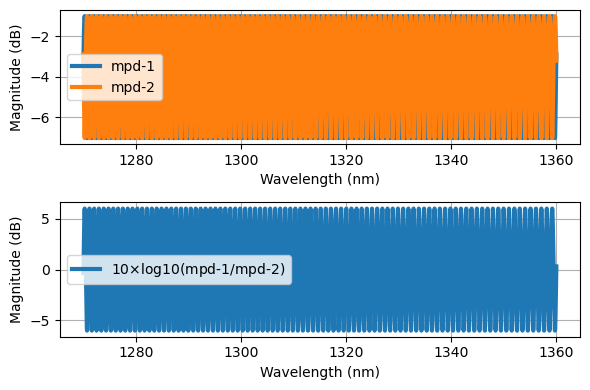

In [7]:
target_wavelength = 1.325e-6

tg = 5e-12

neff = 1.63

delta_L = tg * 3e8 / neff

filter_order = delta_L * neff / target_wavelength

filter_order_int = int(filter_order)
delta_L = filter_order_int * target_wavelength / neff

wavemeter = unbalanced_mzi_filter(dc1=0.5, dc2=0.1, L_arm_1=50*um + delta_L, L_arm_2=50*um)
wavemeter.wavelength = 1.31e-6

input_state_top = np.array([1, 0, 0, 0])
input_state_bottom = np.array([0, 1, 0, 0])

output_state_top = wavemeter.smatrix @ input_state_top
output_state_bottom = wavemeter.smatrix @ input_state_bottom

output_port1_input_top_mag = np.abs(output_state_top[2])**2
output_port_2_input_top_mag = np.abs(output_state_top[3])**2
output_port_1_input_bottom_mag = np.abs(output_state_bottom[2])**2
output_port_2_input_bottom_mag = np.abs(output_state_bottom[3])**2

output_port1_input_top_angle = np.angle(output_state_top[2])
output_port_2_input_top_angle = np.angle(output_state_top[3])
output_port_1_input_bottom_angle = np.angle(output_state_bottom[2])
output_port_2_input_bottom_angle = np.angle(output_state_bottom[3])

print("Output port 1 input top magnitude = ", output_port1_input_top_mag)
print("Output port 2 input top magnitude = ", output_port_2_input_top_mag)
print("Output port 1 input bottom magnitude = ", output_port_1_input_bottom_mag)
print("Output port 2 input bottom magnitude = ", output_port_2_input_bottom_mag)

print("Output port 1 input top angle = ", output_port1_input_top_angle)
print("Output port 2 input top angle = ", output_port_2_input_top_angle)
print("Output port 1 input bottom angle = ", output_port_1_input_bottom_angle)
print("Output port 2 input bottom angle = ", output_port_2_input_bottom_angle)

output_port_1_input_top_mag_list = []
output_port_2_input_top_mag_list = []
output_port_1_input_bottom_mag_list = []
output_port_2_input_bottom_mag_list = []

for wav in wavelength_sweep:
      wavemeter.wavelength = wav

      output_state_top = wavemeter.smatrix @ input_state_top
      output_state_bottom = wavemeter.smatrix @ input_state_bottom

      output_port_1_input_top_mag_list.append(np.abs(output_state_top[2])**2)
      output_port_2_input_top_mag_list.append(np.abs(output_state_top[3])**2)
      output_port_1_input_bottom_mag_list.append(np.abs(output_state_bottom[2])**2)
      output_port_2_input_bottom_mag_list.append(np.abs(output_state_bottom[3])**2)

output_port_1_input_top_mag = np.array(output_port_1_input_top_mag_list)
output_port_2_input_top_mag = np.array(output_port_2_input_top_mag_list)
output_port_1_input_bottom_mag = np.array(output_port_1_input_bottom_mag_list)
output_port_2_input_bottom_mag = np.array(output_port_2_input_bottom_mag_list)

plt.figure(figsize=(6,4))
plt.subplot(211)
plt.plot(wavelength_sweep*1e9, 10*np.log10(output_port_1_input_top_mag), linewidth=3.0, label = 'mpd-1')
plt.plot(wavelength_sweep*1e9, 10*np.log10(output_port_2_input_top_mag), linewidth=3.0, label = 'mpd-2')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()
plt.subplot(212)
plt.plot(wavelength_sweep*1e9, 10*np.log10(output_port_1_input_top_mag/output_port_2_input_top_mag), linewidth=3.0, label = r'10$\times$log10(mpd-1/mpd-2)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Output port 1 input top magnitude =  0.7703620136632525
Output port 2 input top magnitude =  0.22046993077186944
Output port 1 input bottom magnitude =  0.22046993077186944
Output port 2 input bottom magnitude =  0.7703620136615759
Output port 1 input top angle =  1.112636257289574
Output port 2 input top angle =  0.31845535984110096
Output port 1 input bottom angle =  0.3184553598411009
Output port 2 input bottom angle =  2.6658671159834904


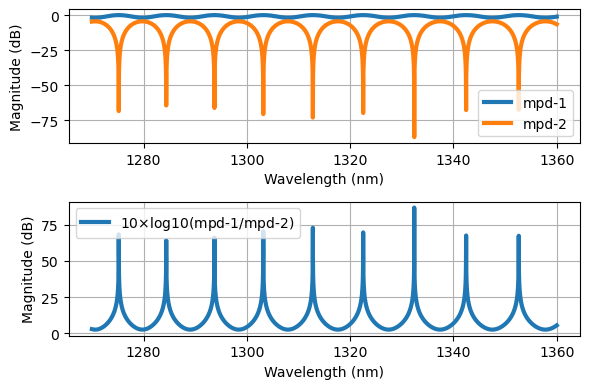

In [22]:
target_wavelength = 1.325e-6

tg = 0.5e-12

neff = 1.63

delta_L = tg * 3e8 / neff

filter_order = delta_L * neff / target_wavelength

filter_order_int = int(filter_order)
delta_L = filter_order_int * target_wavelength / neff

wavemeter = unbalanced_mzi_filter(dc1=0.5, dc2=0.1, L_arm_1=50*um + delta_L, L_arm_2=50*um)
wavemeter.wavelength = 1.31e-6

input_state_top = np.array([1, 0, 0, 0])
input_state_bottom = np.array([0, 1, 0, 0])

output_state_top = wavemeter.smatrix @ input_state_top
output_state_bottom = wavemeter.smatrix @ input_state_bottom

output_port1_input_top_mag = np.abs(output_state_top[2])**2
output_port_2_input_top_mag = np.abs(output_state_top[3])**2
output_port_1_input_bottom_mag = np.abs(output_state_bottom[2])**2
output_port_2_input_bottom_mag = np.abs(output_state_bottom[3])**2

output_port1_input_top_angle = np.angle(output_state_top[2])
output_port_2_input_top_angle = np.angle(output_state_top[3])
output_port_1_input_bottom_angle = np.angle(output_state_bottom[2])
output_port_2_input_bottom_angle = np.angle(output_state_bottom[3])

print("Output port 1 input top magnitude = ", output_port1_input_top_mag)
print("Output port 2 input top magnitude = ", output_port_2_input_top_mag)
print("Output port 1 input bottom magnitude = ", output_port_1_input_bottom_mag)
print("Output port 2 input bottom magnitude = ", output_port_2_input_bottom_mag)

print("Output port 1 input top angle = ", output_port1_input_top_angle)
print("Output port 2 input top angle = ", output_port_2_input_top_angle)
print("Output port 1 input bottom angle = ", output_port_1_input_bottom_angle)
print("Output port 2 input bottom angle = ", output_port_2_input_bottom_angle)

output_port_1_input_top_mag_list = []
output_port_2_input_top_mag_list = []
output_port_1_input_bottom_mag_list = []
output_port_2_input_bottom_mag_list = []

for wav in wavelength_sweep:
      wavemeter.wavelength = wav

      output_state_top = wavemeter.smatrix @ input_state_top
      output_state_bottom = wavemeter.smatrix @ input_state_bottom

      output_port_1_input_top_mag_list.append(np.abs(output_state_top[2])**2)
      output_port_2_input_top_mag_list.append(np.abs(output_state_top[3])**2)
      output_port_1_input_bottom_mag_list.append(np.abs(output_state_bottom[2])**2)
      output_port_2_input_bottom_mag_list.append(np.abs(output_state_bottom[3])**2)

output_port_1_input_top_mag = np.array(output_port_1_input_top_mag_list)
output_port_2_input_top_mag = np.array(output_port_2_input_top_mag_list)
output_port_1_input_bottom_mag = np.array(output_port_1_input_bottom_mag_list)
output_port_2_input_bottom_mag = np.array(output_port_2_input_bottom_mag_list)

plt.figure(figsize=(6,4))
plt.subplot(211)
plt.plot(wavelength_sweep*1e9, 10*np.log10(output_port_1_input_top_mag), linewidth=3.0, label = 'mpd-1')
plt.plot(wavelength_sweep*1e9, 10*np.log10(output_port_2_input_top_mag), linewidth=3.0, label = 'mpd-2')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()
plt.subplot(212)
plt.plot(wavelength_sweep*1e9, 10*np.log10(output_port_1_input_top_mag/output_port_2_input_top_mag), linewidth=3.0, label = r'10$\times$log10(mpd-1/mpd-2)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude (dB)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()